In [1]:
import pandas as pd
import seaborn as sns
import pickle
import numpy as np

sns.set_style("whitegrid")

In [2]:
with open("/data/s1620444/tm/data/bert_tokenized/bert_train_data.pkl", "rb") as f:
    train_dev = pickle.load(f)

with open("/data/s1620444/tm/data/bert_tokenized/bert_test_data.pkl","rb") as f:
    test = pickle.load(f)

In [4]:
lr= [1e-06, 1.0800000000000002e-05, 2.0600000000000003e-05,3.0400000000000004e-05, 4.02e-05,5e-05]
hidden= [True, False]

# dims =  lr x hidden x 3 runs x (train vs val)
results = np.zeros((len(lr), len(hidden),3,2))


In [6]:
for i, l in enumerate(lr):
    for j, h in enumerate(hidden):
        results[i,j,:,:] = np.genfromtxt(f"../results/{l}_{h}.csv", delimiter=",")
        

In [13]:
with open("../results/results.pkl", "wb") as f:
    pickle.dump(results,f)

In [5]:
results_rows = []

# dims =  lr x hidden x 3 runs x (train vs val)
for i, l in enumerate(lr):
    for j, h in enumerate(hidden):
        results = np.genfromtxt(f"../results/{l}_{h}.csv", delimiter=",")
        results_rows.extend([[l, h, results[r][0], results[r][1]] for r in range(3)])


In [6]:
results_df = pd.DataFrame(data=results_rows, columns=["lr", "hidden", "train_acc", "val_acc"])
results_df.head()

,lr,hidden,train_acc,val_acc
0,0.000001,True,71.263654,70.444775
1,0.000001,True,71.555362,70.171958
2,0.000001,True,70.301639,69.506448
3,0.000001,False,71.325720,70.027282
4,0.000001,False,70.841609,70.081019


In [7]:
mean_per_param_combination = results_df.groupby(['lr', 'hidden']).mean().sort_values(by=["val_acc","train_acc"],ascending=False)
mean_per_param_combination.head()

,,train_acc,val_acc
lr,hidden,,
0.000030,False,96.012289,74.805721
0.000011,False,86.340409,74.564594
0.000021,False,93.024868,74.563216
0.000050,False,97.954940,74.502590
0.000021,True,91.787694,74.473655


In [7]:
mean_per_lr = results_df.groupby(['lr']).mean().sort_values(by=["val_acc","train_acc"], ascending=False)
mean_per_lr.head()

,hidden,train_acc,val_acc
lr,,,
0.000021,0.5,92.406281,74.518436
0.000011,0.5,85.890951,74.468144
0.000030,0.5,95.272157,74.466077
0.000050,0.5,97.403074,74.448165
0.000040,0.5,96.570362,74.335869


In [8]:
mean_per_hidden = results_df.groupby(['hidden'])[['train_acc','val_acc']].mean().sort_values(by=["val_acc","train_acc"], ascending=False)
mean_per_hidden.head()

,train_acc,val_acc
hidden,,
False,90.328292,73.834325
True,89.258696,73.616852


<h1> heatmap of params, compare train/val acc? </h1>

In [31]:
mean_per_param_combination.reset_index().lr.unique()

array([3.04e-05, 1.08e-05, 2.06e-05, 5.00e-05, 4.02e-05, 1.00e-06])

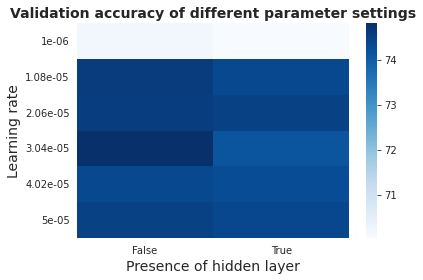

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
sns.heatmap(mean_per_param_combination.reset_index()[["lr", "hidden","val_acc"]].pivot("lr", "hidden","val_acc"),cmap = "Blues",ax=ax)
ax.set_ylabel("Learning rate",size=14)
ax.set_yticklabels([1.00e-06,1.08e-05,2.06e-05,3.04e-05, 4.02e-05, 5.00e-05])
ax.set_xlabel("Presence of hidden layer",size=14)
ax.set_title("Validation accuracy of different parameter settings", weight="bold", size=14)
plt.tight_layout()
plt.savefig("../plots/param_heatmap.pdf")
plt.show()

<h1> train & eval best model 3 x on train_val data </h1>

In [21]:
def bert_confusion_matrix(id, true_labels):
    """ returns confusion matrix and predicted labels"""
    reverse_map = {0: "negative", 1:"neutral",2:"positive"}

    pred_prob = np.load(f"../results/best_predictions_{id}.npy")
    pred = pred_prob.argmax(1)
    return pd.crosstab(pd.Series([i for i in true_labels], name = "True"), pd.Series([reverse_map[i] for i in pred], name = "Predicted"), margins=True), pred



In [22]:
true_labels = test.label.values

df_confusion_0, pred_0 = bert_confusion_matrix(0, true_labels)
df_confusion_1, pred_1 = bert_confusion_matrix(1, true_labels)
df_confusion_2, pred_2 = bert_confusion_matrix(2, true_labels)

In [26]:
df_confusion_0

Predicted,negative,neutral,positive,All
True,,,,
negative,916,550,100,1566
neutral,627,2282,516,3425
positive,191,1949,2696,4836
All,1734,4781,3312,9827


In [33]:
# get precision, recall, accuracy, f1
def precision(df, sent):
    numerator = df.loc[sent, sent]
    denominator = df.loc["All", sent]
    return numerator/denominator

def recall(df, sent):
    numerator = df.loc[sent, sent]
    denominator = df.loc["All", sent]
    return numerator/denominator

def f1(p,r):
    return 2*(p*r)/(p+r)

def f1pn(fp, fn):
    return 0.5*(fp+fn)

confusion_dfs = [df_confusion_0, df_confusion_1, df_confusion_2]
precisions = np.array([[precision(d, "negative"), precision(d, "neutral"), precision(d,"positive")] for d in confusion_dfs])
recalls = np.array([[recall(d, "negative"), recall(d, "neutral"), recall(d,"positive")] for d in confusion_dfs])
f1s = np.array([[f1(precisions[i][j], recalls[i][j]) for j in range(3)] for i in range(3)])
avg_f1 = np.array([f1pn(f1s[i][0], f1s[i][2]) for i in range(3)])


In [40]:
df_eval = pd.DataFrame(data = np.column_stack((np.concatenate((precisions,recalls,f1s),axis=1),avg_f1)), columns=["p_neg", "p_neu", "p_pos", "r_neg", "r_neu", "r_pos", "f1_neg", "f1_neu", "f1_pos", "f1_pn"])

[[0.52825836 0.477306   0.81400966]
 [0.52328289 0.47795341 0.81884277]
 [0.53191489 0.47583418 0.81835032]]
[[0.52825836 0.477306   0.81400966]
 [0.52328289 0.47795341 0.81884277]
 [0.53191489 0.47583418 0.81835032]]


In [44]:
print(df_eval.var(axis=0))
df_eval.mean()

p_neg     0.000019
p_neu     0.000001
p_pos     0.000007
r_neg     0.000019
r_neu     0.000001
r_pos     0.000007
f1_neg    0.000019
f1_neu    0.000001
f1_pos    0.000007
f1_pn     0.000005
dtype: float64


p_neg     0.527819
p_neu     0.477031
p_pos     0.817068
r_neg     0.527819
r_neu     0.477031
r_pos     0.817068
f1_neg    0.527819
f1_neu    0.477031
f1_pos    0.817068
f1_pn     0.672443
dtype: float64

<h1> baseline </h1>

In [45]:
with open("../results/baseline_predictions.pkl", "rb") as f:
    baseline_predictions = pickle.load(f)

In [47]:
from sklearn.metrics import recall_score, precision_score, f1_score

labels_map = {"negative":0, "neutral":1, "positive":2}
y_true = [labels_map[i] for i in true_labels]
baseline_precisions = np.array([precision_score(y_true,pred,average=None).tolist() for pred in baseline_predictions])
baseline_recalls = np.array([recall_score(y_true,pred,average=None).tolist() for pred in baseline_predictions])
baseline_f1s = np.array([f1_score(y_true,pred,average=None).tolist() for pred in baseline_predictions])
baseline_avg_f1s = np.array([0.5*(baseline_f1s[i][0] + baseline_f1s[i][2]) for i in range(3)])

df_baseline_eval = pd.DataFrame(data = np.column_stack((np.concatenate((baseline_precisions,baseline_recalls,baseline_f1s),axis=1),baseline_avg_f1s)), columns=["p_neg", "p_neu", "p_pos", "r_neg", "r_neu", "r_pos", "f1_neg", "f1_neu", "f1_pos", "f1_pn"])

In [48]:
df_baseline_eval

,p_neg,p_neu,p_pos,r_neg,r_neu,r_pos,f1_neg,f1_neu,f1_pos,f1_pn
0,0.475162,0.43167,0.734067,0.280971,0.732263,0.469189,0.35313,0.543151,0.572474,0.462802
1,0.475162,0.43167,0.734067,0.280971,0.732263,0.469189,0.35313,0.543151,0.572474,0.462802
2,0.475162,0.43167,0.734067,0.280971,0.732263,0.469189,0.35313,0.543151,0.572474,0.462802


In [55]:
df_final_results = pd.concat([df_eval.mean(), df_baseline_eval.mean(), df_eval.var(),df_baseline_eval.var()], axis=1).rename(columns={0:"bert_mean", 1:"baseline_mean", 2:"bert_var", 3:"baseline_var"})

In [57]:
df_final_results["diff"] = df_final_results["bert_mean"]-df_final_results["baseline_mean"]
df_final_results

,bert_mean,baseline_mean,bert_var,baseline_var,diff
p_neg,0.527819,0.475162,0.000019,4.622232e-33,0.052657
p_neu,0.477031,0.431670,0.000001,4.622232e-33,0.045362
p_pos,0.817068,0.734067,0.000007,0.000000e+00,0.083001
r_neg,0.527819,0.280971,0.000019,0.000000e+00,0.246848
r_neu,0.477031,0.732263,0.000001,0.000000e+00,-0.255232
r_pos,0.817068,0.469189,0.000007,0.000000e+00,0.347878
f1_neg,0.527819,0.353130,0.000019,0.000000e+00,0.174689
f1_neu,0.477031,0.543151,0.000001,0.000000e+00,-0.066120
f1_pos,0.817068,0.572474,0.000007,0.000000e+00,0.244594
f1_pn,0.672443,0.462802,0.000005,4.622232e-33,0.209641
